## Telecommunication Sector Model

In [1]:
#%pip install quandl

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_error as mae
from functools import reduce


### Load target variable data

In [3]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('PE_daily_normalized_tele.csv')
pe_ratio.head()

,Dates,PE
0,Aug-24-2001,21.84x
1,Aug-27-2001,21.54x
2,Aug-28-2001,21.34x
3,Aug-29-2001,21.16x
4,Aug-30-2001,21.09x


In [4]:
# load telecommunication index price -- also from Capital IQ
price = pd.read_csv('daily_price_tele.csv')
price.head()

,Dates,Value
0,Aug-01-2001,198.68
1,Aug-02-2001,195.27
2,Aug-03-2001,193.28
3,Aug-06-2001,191.48
4,Aug-07-2001,191.19


In [5]:
# load 10 year treasury rate
quandl.ApiConfig.api_key = "91nyd8SyzTFzVtMSfKPJ"

treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [6]:
# rename, change type
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date", "PE" : "PE"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

pe_ratio['PE'] = pe_ratio['PE'].str.rstrip('x')
pe_ratio['PE'] = pd.to_numeric(pe_ratio['PE'])
pe_ratio.head()

,PE
Date,
2001-08-24,21.84
2001-08-27,21.54
2001-08-28,21.34
2001-08-29,21.16
2001-08-30,21.09


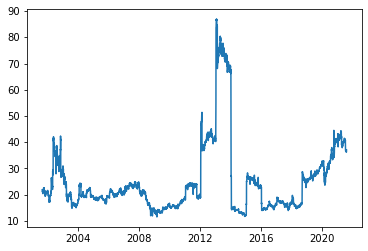

In [7]:
plt.plot(pe_ratio.PE)

In [8]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')

price.head()

,Price
Date,
2001-08-01,198.68
2001-08-02,195.27
2001-08-03,193.28
2001-08-06,191.48
2001-08-07,191.19


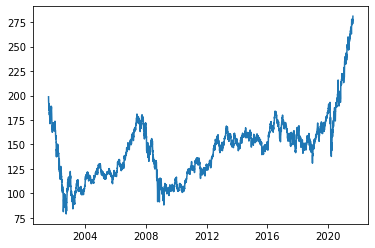

In [9]:
plt.plot(price.Price)

In [10]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


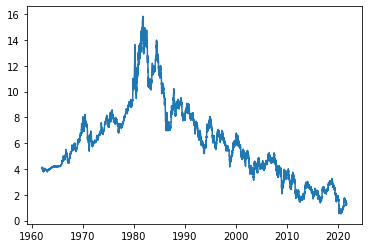

In [11]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [12]:
joined = pe_ratio.join(price).join(treasury)
joined.head()

,PE,Price,treasury_rate
Date,,,
2001-08-24,21.84,183.24,4.93
2001-08-27,21.54,180.65,4.94
2001-08-28,21.34,179.19,4.85
2001-08-29,21.16,177.58,4.78
2001-08-30,21.09,176.92,4.79


In [13]:
joined['month'] = joined.index.month
joined['year'] = joined.index.year

joined = joined.groupby([joined.year, joined.month]).mean()
joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      21.358333  179.221667       4.856667
     9      21.543333  180.474000       4.748667
     10     21.277391  177.617391       4.566818
     11     20.492381  167.864762       4.651500
     12     20.719000  167.026000       5.087500

In [14]:
joined = joined.reset_index()
joined['date'] = pd.to_datetime(joined[['year', 'month']].assign(DAY=1))
joined = joined.set_index('date')
joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667
2001-09-01,2001,9,21.543333,180.474000,4.748667
2001-10-01,2001,10,21.277391,177.617391,4.566818
2001-11-01,2001,11,20.492381,167.864762,4.651500
2001-12-01,2001,12,20.719000,167.026000,5.087500


In [15]:
joined['earnings'] = joined.Price / joined.PE
joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667,8.391182
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489


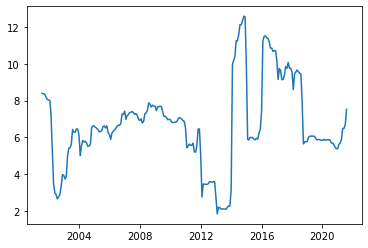

In [16]:
plt.plot(joined.earnings)

In [17]:
joined['earnings_change'] = joined.earnings.pct_change()
display(joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change
date,,,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667,8.391182,NaN
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255,-0.001660
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705,-0.003527
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569,-0.018704
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489,-0.015880
...,...,...,...,...,...,...,...
2021-04-01,2021,4,42.774500,251.382000,1.628000,5.876913,0.031792
2021-05-01,2021,5,39.058500,253.229000,1.621000,6.483326,0.103186
2021-06-01,2021,6,40.197368,260.633684,1.524211,6.483849,0.000081


In [18]:
#set the cap
#joined.loc[joined['earnings_change'] > 0.5] = 0.5

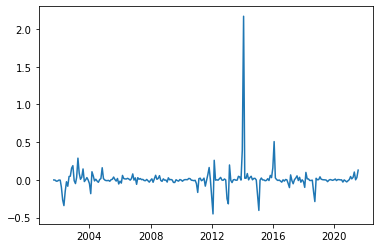

In [19]:
plt.plot(joined.earnings_change)

In [20]:
joined['target'] = joined.earnings_change - ((1 + joined.treasury_rate/100)**(1/12) - 1)
joined = joined.dropna()
joined.head()

,year,month,PE,Price,treasury_rate,earnings,earnings_change,target
date,,,,,,,,
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255,-0.001660,-0.005533
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705,-0.003527,-0.007256
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569,-0.018704,-0.022500
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489,-0.015880,-0.020024
2002-01-01,2002,1,20.239048,162.613810,5.035714,8.034657,-0.003328,-0.007431


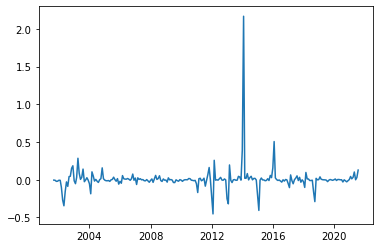

In [21]:
plt.plot(joined.target)

In [22]:
target = joined['target'].to_frame()
target.head()

,target
date,
2001-09-01,-0.005533
2001-10-01,-0.007256
2001-11-01,-0.022500
2001-12-01,-0.020024
2002-01-01,-0.007431


## Load exogenous Variables

In [23]:
def get_df_name(df):
    # grabs name of dataframe to be used as variable name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def var_change(df):
    df_name = get_df_name(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.set_index('Date')

    df = df.rename(columns = {'Value':df_name}).drop(columns = ['year', 'month'])

    df_mom_ch = df.rename(columns = {df_name : df_name + '_mom_ch'})
    df_mom_ch = df_mom_ch[df_name + '_mom_ch'].diff(1)/ df_mom_ch[df_name + '_mom_ch']

    df_yoy_ch = df.rename(columns = {df_name : df_name + '_yoy_ch'})
    df_yoy_ch = df_yoy_ch[df_name + '_yoy_ch'].diff(12)/ df_yoy_ch[df_name + '_yoy_ch']

    df_final = pd.DataFrame(df_mom_ch).join(df_yoy_ch).join(df)
    
    return df_final

## Load Quandl indicators

In [24]:
# CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
cpi = quandl.get('FRED/CPIAUCSL')
cpi.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [25]:
# WPU117601 - Producer Price Index by Commodity: Machinery and Equipment: Telephone and Wireline Data Networking Equipment
ppi_w = quandl.get('FRED/WPU117601')
ppi_w.head()

,Value
Date,
1985-12-01,100.0
1986-01-01,101.1
1986-02-01,101.1
1986-03-01,101.4
1986-04-01,101.4


In [26]:
# ITMTCIM133S - U.S. Imports of Services: Telecommunications, Computer, and Information Services
imp = quandl.get('FRED/ITMTCIM133S')
imp.head()

,Value
Date,
1999-01-01,1252.0
1999-02-01,1252.0
1999-03-01,1252.0
1999-04-01,1252.0
1999-05-01,1249.0


In [27]:
# ITXTCIM133S - U.S. Exports of Services: Telecommunications, Computer, and Information Services
exp = quandl.get('FRED/ITXTCIM133S')
exp.head()

,Value
Date,
1999-01-01,1019.0
1999-02-01,1018.0
1999-03-01,1016.0
1999-04-01,1012.0
1999-05-01,1011.0


In [28]:
# find month-on-month growth and year-on-year growth
cpi_new = var_change(cpi)
ppi_w_new = var_change(ppi_w)
imp_new = var_change(imp)
exp_new = var_change(exp)

### Joined dataframe

In [29]:
# join all exogenous variables
ex_list = [cpi_new,ppi_w_new,imp_new,exp_new]
ex_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), ex_list)
ex_merged.head()

,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,exp_mom_ch,exp_yoy_ch,exp
Date,,,,,,,,,,,,
1947-01-01,NaN,NaN,21.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-02-01,0.006475,NaN,21.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-03-01,0.017273,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-01,0.000000,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-05-01,-0.002278,NaN,21.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
ex_final = ex_merged
ex_final.columns

Index(['cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'ppi_w', 'imp_mom_ch', 'imp_yoy_ch', 'imp', 'exp_mom_ch', 'exp_yoy_ch',
       'exp'],
      dtype='object')

### Create feature lags

In [31]:
# this lags features in ex_columns in the range of periods in lag_periods

ex_columns = ['cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'ppi_w', 'imp_mom_ch', 'imp_yoy_ch', 'imp', 'exp_mom_ch', 'exp_yoy_ch',
       'exp']

lag_periods = list(range(1,14))
def add_lags(var_names, lag_periods):
    for var in var_names:
        for lag in lag_periods:
            var_col = var + '_' + str(lag)
            ex_final[var_col] = ex_final[var].shift(lag)
            
add_lags(ex_columns, lag_periods)

In [37]:
st1 = pd.read_csv('st_prediction1.csv')
st1['Date'] = pd.to_datetime(st1['Date'])
st1 = st1.set_index('Date')
st1['market1'] = pd.to_numeric(st1['market1'])
st1.head()

,market1
Date,
2001-09-01,-0.450016
2001-10-01,-0.414976
2001-11-01,-0.242129
2001-12-01,-0.608143
2002-01-01,-0.612288


In [38]:
st3 = pd.read_csv('three_month_prediction.csv')
st3['Date'] = pd.to_datetime(st3['Date'])
st3 = st3.set_index('Date')
st3['market3'] = pd.to_numeric(st3['market3'])
st3.head()

,market3
Date,
2001-09-01,-0.223276
2001-10-01,-0.050709
2001-11-01,-0.468662
2001-12-01,-0.405413
2002-01-01,-0.290757


In [39]:
st6 = pd.read_csv('six_month_prediction.csv')
st6['Date'] = pd.to_datetime(st6['Date'])
st6 = st6.set_index('Date')
st6['market6'] = pd.to_numeric(st6['market6'])
st6.head()

,market6
Date,
2001-09-01,-0.443436
2001-10-01,-0.613667
2001-11-01,-0.180843
2001-12-01,-0.165990
2002-01-01,-0.090202


In [40]:
st12 = pd.read_csv('twelve_month_prediction.csv')
st12['Date'] = pd.to_datetime(st12['Date'])
st12 = st12.set_index('Date')
st12['market12'] = pd.to_numeric(st12['market12'])
st12.head()

,market12
Date,
2001-09-01,0.105585
2001-10-01,3.037121
2001-11-01,2.871684
2001-12-01,3.588042
2002-01-01,3.011999


In [41]:
# join with target variable

df1 = st1.join(ex_final)
df3 = st3.join(df1)
df6 = st6.join(df3)
df12 = st12.join(df6)
final_df = target.join(df12)
final_df.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.005533,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.1,0.000000,-0.056459,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0
2001-10-01,-0.007256,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.6,0.000000,-0.054545,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0
2001-11-01,-0.022500,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.5,-0.001918,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0
2001-12-01,-0.020024,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.4,0.000000,-0.056568,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0
2002-01-01,-0.007431,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.7,-0.000960,-0.057582,...,1059.0,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0


In [42]:
# look at any NAs
final_df[final_df.isna().any(1)]

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2021-04-01,0.030445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,0.101845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,-0.001181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,0.028076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01,0.127284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# remove latest periods with missing data
df = final_df.iloc[:-5]
df.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2020-11-01,-0.028466,-0.023348,0.227182,0.027331,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0
2020-12-01,-0.014038,-0.017484,0.183293,0.016424,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0
2021-01-01,0.001549,-0.051593,0.089681,0.004035,-0.000172,0.002559,0.013515,262.231,-0.009685,0.013317,...,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0
2021-02-01,0.042618,0.519621,-0.001906,-0.000868,-0.000759,0.003534,0.016480,263.161,0.003619,0.007238,...,4989.0,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0
2021-03-01,0.011291,0.854688,-0.007756,-0.000918,-0.000566,0.006163,0.025696,264.793,-0.004848,-0.003636,...,5208.0,4989.0,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0


## Feature Correlation

In [44]:
var_corr = (df.corr().sort_values('target'))
var_corr.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
imp_mom_ch_9,0.115069,-0.099829,0.228851,-0.009685,0.128413,0.002008,0.247684,-0.162923,0.048076,-0.014429,...,-0.204432,-0.206871,-0.208526,-0.209764,-0.212314,-0.217074,-0.223293,-0.230087,-0.236462,-0.242000
ppi_w_yoy_ch_1,0.120972,-0.317144,-0.169814,-0.274051,-0.293096,-0.058252,-0.169810,0.687145,0.010201,0.918835,...,0.594803,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192
ppi_w_yoy_ch_2,0.124468,-0.310059,-0.150986,-0.259903,-0.290504,-0.010634,-0.160093,0.690214,0.010328,0.850089,...,0.597571,0.595455,0.592796,0.589918,0.587282,0.584981,0.582743,0.580574,0.578313,0.576281
imp_mom_ch_10,0.144623,-0.069538,0.165337,0.010657,0.069834,-0.010904,0.214157,-0.151209,0.057236,-0.002626,...,-0.190591,-0.192365,-0.195366,-0.197969,-0.199758,-0.202409,-0.206816,-0.212779,-0.219391,-0.225716
target,1.000000,-0.002682,0.067225,0.005044,-0.048456,-0.058515,-0.014914,0.028942,0.055558,0.108407,...,0.026239,0.022830,0.020253,0.018561,0.017770,0.017399,0.017369,0.017417,0.017542,0.018226


In [45]:
var_corr

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
cpi_yoy_ch_10,-0.123838,0.251815,-0.199322,-0.337079,-0.243939,0.040154,0.084825,-0.288416,-0.013268,-0.105062,...,-0.314906,-0.315794,-0.316017,-0.316065,-0.315495,-0.313947,-0.311834,-0.310461,-0.310772,-0.312688
cpi_yoy_ch_11,-0.102447,0.261622,-0.280032,-0.300085,-0.228583,0.022016,0.005331,-0.285688,-0.019186,-0.097925,...,-0.306699,-0.308990,-0.310439,-0.311716,-0.312395,-0.311932,-0.309920,-0.307441,-0.305779,-0.305974
cpi_yoy_ch_9,-0.100167,0.258466,-0.113470,-0.352466,-0.272079,0.029977,0.157066,-0.288958,-0.026632,-0.114132,...,-0.318254,-0.318224,-0.317732,-0.316817,-0.315210,-0.313360,-0.312186,-0.312646,-0.314615,-0.317517
cpi_mom_ch_11,-0.092327,0.066391,0.089854,-0.158871,-0.067938,0.037886,0.266680,-0.109432,0.005623,-0.043596,...,-0.131790,-0.128644,-0.124579,-0.121068,-0.118053,-0.116282,-0.116383,-0.119396,-0.124691,-0.130857
cpi_mom_ch_10,-0.092012,0.000854,0.122231,-0.172117,-0.104800,0.057273,0.363114,-0.116181,0.037491,-0.082860,...,-0.135796,-0.131358,-0.127133,-0.123702,-0.121867,-0.122276,-0.125514,-0.130968,-0.137174,-0.141921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imp_mom_ch_9,0.115069,-0.099829,0.228851,-0.009685,0.128413,0.002008,0.247684,-0.162923,0.048076,-0.014429,...,-0.204432,-0.206871,-0.208526,-0.209764,-0.212314,-0.217074,-0.223293,-0.230087,-0.236462,-0.242000
ppi_w_yoy_ch_1,0.120972,-0.317144,-0.169814,-0.274051,-0.293096,-0.058252,-0.169810,0.687145,0.010201,0.918835,...,0.594803,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192
ppi_w_yoy_ch_2,0.124468,-0.310059,-0.150986,-0.259903,-0.290504,-0.010634,-0.160093,0.690214,0.010328,0.850089,...,0.597571,0.595455,0.592796,0.589918,0.587282,0.584981,0.582743,0.580574,0.578313,0.576281
imp_mom_ch_10,0.144623,-0.069538,0.165337,0.010657,0.069834,-0.010904,0.214157,-0.151209,0.057236,-0.002626,...,-0.190591,-0.192365,-0.195366,-0.197969,-0.199758,-0.202409,-0.206816,-0.212779,-0.219391,-0.225716


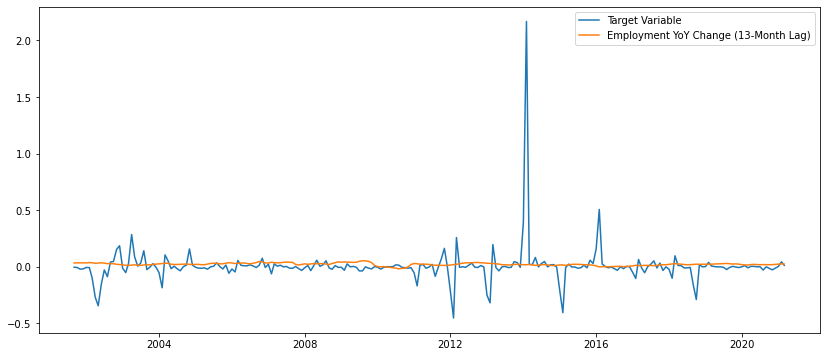

In [46]:
plt.figure(figsize = (14, 6))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.cpi_yoy_ch_13, label = 'Employment YoY Change (13-Month Lag)')
plt.legend()

Notes:
- we would include highest and lowest correlation features
- in 1-2 months ahead, soc and unemp have large correlation
- around half year: cpi has large correlation
- 10-plus periods: unemp and emp 

## Shift target variables for 1, 3, 6, 12, 18 months

In [47]:
df_1 = df
df_1 = df_1.reset_index()
df_1['target'] = df_1.target.shift(-1)
df_1['date'] = df_1.date.shift(-1)
df_1 = df_1.dropna()
df_1 = df_1.set_index('date')
df_1['month'] = df_1.index.month
df_1

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,-0.007256,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,10
2001-11-01,-0.022500,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,11
2001-12-01,-0.020024,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,12
2002-01-01,-0.007431,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1
2002-02-01,-0.008379,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,-0.092458,-0.113598,0.160532,0.013084,0.001202,0.011806,260.462,-0.009709,0.010922,...,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,11
2020-12-01,-0.014038,-0.023348,0.227182,0.027331,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,...,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,12
2021-01-01,0.001549,-0.017484,0.183293,0.016424,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,1


In [48]:
df_3 = df
df_3 = df_3.reset_index()
df_3['target'] = df_3.target.shift(-3)
df_3['date'] = df_3.date.shift(-3)
df_3 = df_3.dropna()
df_3 = df_3.set_index('date')
df_3['month'] = df_3.index.month
df_3

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-12-01,-0.020024,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,12
2002-01-01,-0.007431,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1
2002-02-01,-0.008379,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,2
2002-03-01,-0.099550,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,3
2002-04-01,-0.270032,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,-0.040981,0.052744,0.302812,0.109614,0.003495,0.013075,259.511,0.002410,0.006024,...,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,11
2020-12-01,-0.014038,-0.007526,-0.060056,0.342372,0.023037,0.002452,0.013904,260.149,0.002404,0.006010,...,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,12
2021-01-01,0.001549,-0.092458,-0.113598,0.160532,0.013084,0.001202,0.011806,260.462,-0.009709,0.010922,...,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,1


In [49]:
df_6 = df
df_6 = df_6.reset_index()
df_6['target'] = df_6.target.shift(-6)
df_6['date'] = df_6.date.shift(-6)
df_6 = df_6.dropna()
df_6 = df_6.set_index('date')
df_6['month'] = df_6.index.month
df_6

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2002-03-01,-0.099550,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,3
2002-04-01,-0.270032,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,4
2002-05-01,-0.346031,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,5
2002-06-01,-0.156167,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,6
2002-07-01,-0.029472,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,-0.083088,0.119794,0.085725,-0.453452,-0.000977,0.002231,255.942,0.010870,0.000000,...,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,4682.0,4636.0,4532.0,11
2020-12-01,-0.014038,-0.104667,0.145287,-0.059290,0.368348,0.005208,0.007226,257.282,-0.009756,-0.009756,...,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,4682.0,4636.0,12
2021-01-01,0.001549,-0.077917,0.035580,-0.353247,0.192666,0.005112,0.010359,258.604,0.009662,0.000000,...,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,4682.0,1


In [50]:
df_12 = df
df_12 = df_12.reset_index()
df_12['target'] = df_12.target.shift(-12)
df_12['date'] = df_12.date.shift(-12)
df_12 = df_12.dropna()
df_12 = df_12.set_index('date')
df_12['month'] = df_12.index.month
df_12

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2002-09-01,0.040499,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,9
2002-10-01,0.045425,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,10
2002-11-01,0.151730,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,11
2002-12-01,0.184430,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,12
2003-01-01,-0.014347,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,0.008420,0.097071,-0.019553,0.008040,0.002333,0.020028,257.989,0.012121,-0.001212,...,4682.0,4636.0,4532.0,4372.0,4262.0,4203.0,4194.0,4156.0,4090.0,11
2020-12-01,-0.014038,0.014825,0.095254,0.008484,0.024932,0.000829,0.022114,258.203,0.003623,0.000000,...,4672.0,4682.0,4636.0,4532.0,4372.0,4262.0,4203.0,4194.0,4156.0,12
2021-01-01,0.001549,-0.041804,0.078172,0.020064,0.047709,0.001871,0.024145,258.687,-0.015951,-0.019632,...,4670.0,4672.0,4682.0,4636.0,4532.0,4372.0,4262.0,4203.0,4194.0,1


In [51]:
df_18 = df
df_18 = df_18.reset_index()
df_18['target'] = df_18.target.shift(-18)
df_18['date'] = df_18.date.shift(-18)
df_18 = df_18.dropna()
df_18 = df_18.set_index('date')
df_18['month'] = df_18.index.month
df_18

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2003-03-01,0.028986,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,3
2003-04-01,0.284133,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,4
2003-05-01,0.086355,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,5
2003-06-01,0.004287,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,6
2003-07-01,0.030822,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,0.026347,-0.009335,-0.005771,-0.026062,0.000176,0.017954,255.371,0.001208,-0.006039,...,4194.0,4156.0,4090.0,3995.0,3958.0,3977.0,4054.0,4114.0,4156.0,11
2020-12-01,-0.014038,0.035868,-0.018918,0.005186,-0.004718,0.000204,0.016721,255.423,0.000000,-0.006039,...,4203.0,4194.0,4156.0,4090.0,3995.0,3958.0,3977.0,4054.0,4114.0,12
2021-01-01,0.001549,0.059741,0.020888,-0.008838,0.002027,0.001962,0.017896,255.925,0.000000,0.003623,...,4262.0,4203.0,4194.0,4156.0,4090.0,3995.0,3958.0,3977.0,4054.0,1


# Model

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from PlotForecast import plot_forecast

## SARIMA Model - 1 month

In [53]:
var_corr_1 = (df_1.corr().sort_values('target'))
var_corr_1.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_9,-0.123868,0.266862,-0.114533,-0.354300,-0.274127,0.037334,0.159971,-0.283271,-0.029645,-0.111905,...,-0.312094,-0.312164,-0.311600,-0.310042,-0.307913,-0.306528,-0.306838,-0.308764,-0.311641,0.021633
ppi_w_yoy_ch_13,-0.113896,-0.049006,-0.162843,-0.180451,-0.193690,-0.119813,-0.416314,0.622832,0.116622,0.459604,...,0.572342,0.574269,0.575958,0.576905,0.577069,0.576254,0.575264,0.574255,0.573380,-0.012553
cpi_yoy_ch_10,-0.102422,0.263386,-0.201400,-0.340043,-0.247012,0.050484,0.088654,-0.280147,-0.017414,-0.102044,...,-0.306497,-0.307804,-0.308496,-0.308029,-0.306002,-0.303505,-0.301831,-0.302025,-0.303859,0.013686
cpi_yoy_ch_8,-0.100138,0.274509,-0.053530,-0.335705,-0.274607,0.024551,0.232203,-0.283559,-0.011124,-0.107347,...,-0.313808,-0.312910,-0.311302,-0.309441,-0.308257,-0.308715,-0.310693,-0.313611,-0.316797,0.020098
cpi_mom_ch_10,-0.092322,0.006149,0.121835,-0.173123,-0.106022,0.063335,0.365839,-0.110469,0.035253,-0.080979,...,-0.124859,-0.121332,-0.118305,-0.116529,-0.116631,-0.119655,-0.124968,-0.131154,-0.135878,-0.095100


In [54]:
var_corr_1.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
imp_mom_ch_8,0.115004,-0.124610,0.236325,0.024149,0.158379,-0.006833,0.277806,-0.167271,0.019719,-0.028204,...,-0.211571,-0.212792,-0.215343,-0.220121,-0.226366,-0.233189,-0.239590,-0.245149,-0.249503,-0.057253
ppi_w_yoy_ch,0.121649,-0.334977,-0.165306,-0.266359,-0.291861,-0.082235,-0.163484,0.682042,0.257672,1.000000,...,0.585818,0.583147,0.580814,0.578597,0.576415,0.574122,0.572060,0.570331,0.569239,0.011009
ppi_w_yoy_ch_1,0.124765,-0.326048,-0.169509,-0.273909,-0.292619,-0.065918,-0.172799,0.685104,0.013197,0.919262,...,0.589410,0.586535,0.583887,0.581564,0.579301,0.577107,0.574821,0.572769,0.571047,0.007967
imp_mom_ch_9,0.144572,-0.093432,0.228737,-0.010665,0.127433,0.009677,0.251150,-0.155515,0.045125,-0.011694,...,-0.198747,-0.201336,-0.203122,-0.205785,-0.210212,-0.216202,-0.222842,-0.229192,-0.234709,0.015768
target,1.000000,-0.045092,0.079883,0.038037,-0.021744,0.026938,0.010274,0.030189,0.012056,0.121649,...,0.019997,0.018301,0.017508,0.017136,0.017105,0.017153,0.017279,0.017965,0.019507,-0.016388


In [55]:
X1 = df_1.drop(['target'],axis = 1)
X1.head()

,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.1,0.000000,-0.056459,104.5,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,10
2001-11-01,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.6,0.000000,-0.054545,104.5,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,11
2001-12-01,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.5,-0.001918,-0.056568,104.3,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,12
2002-01-01,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.4,0.000000,-0.056568,104.3,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1
2002-02-01,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.7,-0.000960,-0.057582,104.2,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,2


In [56]:
y1 = df_1.target
y1

date
2001-10-01   -0.007256
2001-11-01   -0.022500
2001-12-01   -0.020024
2002-01-01   -0.007431
2002-02-01   -0.008379
                ...   
2020-11-01   -0.028466
2020-12-01   -0.014038
2021-01-01    0.001549
2021-02-01    0.042618
2021-03-01    0.011291
Name: target, Length: 234, dtype: float64

In [57]:
feature_names = X1.columns.values
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe = RFE(LinearRegression(), 
          n_features_to_select=5, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X1,y1)
feature_names[rfe.get_support()]

array(['cpi_yoy_ch_2', 'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13',
       'ppi_w_yoy_ch_1', 'ppi_w_yoy_ch_2'], dtype=object)

In [58]:
model_exvar = ['cpi_mom_ch', 'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13',
       'ppi_w_yoy_ch_1', 'ppi_w_yoy_ch_2','market1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [59]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  184
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                  25.643
Date:                             Tue, 31 Aug 2021   AIC                            -31.285
Time:                                     13:16:05   BIC                              0.190
Sample:                                          0   HQIC                           -18.515
                                             - 184                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.7257     11.336      0.505      0.613     -16.492      27.943
x2           139.4450    14

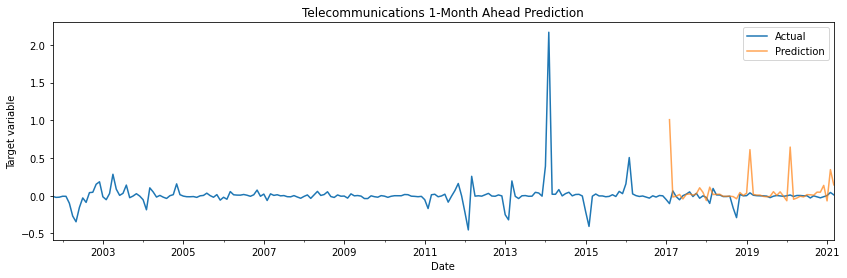

In [60]:
sarimax_model = SARIMAX(y_train, 
                order = (1,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sarimax_mod_fit = sarimax_model.fit()

sarimax_pred = sarimax_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar_pred = sarimax_pred.predicted_mean
sar_pred_ci = sarimax_pred.conf_int()
ax = df_1.target.plot(label='Actual')
sar_pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 1-Month Ahead Prediction')
plt.legend()
plt.show()


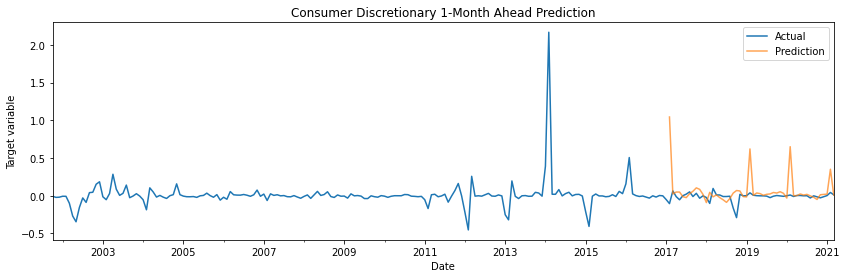

In [146]:
sarimax_model = SARIMAX(y_train, 
                order = (1,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar1_mod_fit = sarimax_model.fit()

sar1_pred = sar1_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar1_pred_mean = sar1_pred.predicted_mean
sar1_pred_ci = sar1_pred.conf_int(alpha = 0.5)
ax = df_1.target.plot(label='Actual')
sar1_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 1-Month Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

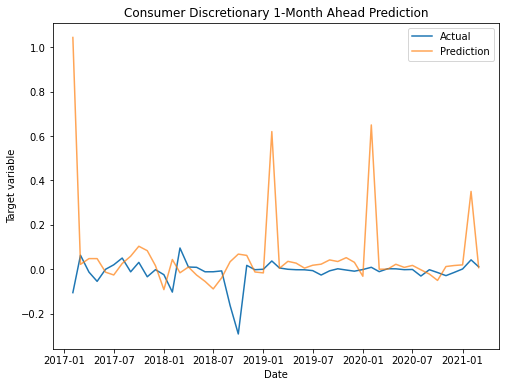

In [147]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_1[df_1.index >= first_date].index, df_1[df_1.index >= first_date].target, label = 'Actual')
ax.plot(sar1_pred_mean.index, sar1_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 1-Month Ahead Prediction')
plt.legend()
plt.show()

In [61]:
def forecast_accuracy(forecast, actual):
    '''
    These are some accuracy metrics we use to compare how accurate our forecast values are.
    '''
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax                
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [62]:
metrics1 = forecast_accuracy(y_test, sar_pred)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 1.55666
MAE: 0.09565


In [63]:
sar1_pred = sarimax_pred.predicted_mean
sar1_pred_ci = sarimax_pred.conf_int()

pred_results1 = pd.DataFrame(df_1.target).join(sar1_pred).join(sar1_pred_ci)
pred_results1

,target,predicted_mean,lower target,upper target
date,,,,
2001-10-01,-0.007256,NaN,NaN,NaN
2001-11-01,-0.022500,NaN,NaN,NaN
2001-12-01,-0.020024,NaN,NaN,NaN
2002-01-01,-0.007431,NaN,NaN,NaN
2002-02-01,-0.008379,NaN,NaN,NaN
...,...,...,...,...
2020-11-01,-0.028466,0.046252,-0.448539,0.541042
2020-12-01,-0.014038,0.136470,-0.358321,0.631260
2021-01-01,0.001549,-0.068901,-0.563692,0.425889


* Index converted to datetime. Please verify example below.
from 2001-10-01 00:00:00 to 2001-10-01 00:00:00

* Dropping duplicate index values. Keeping last.



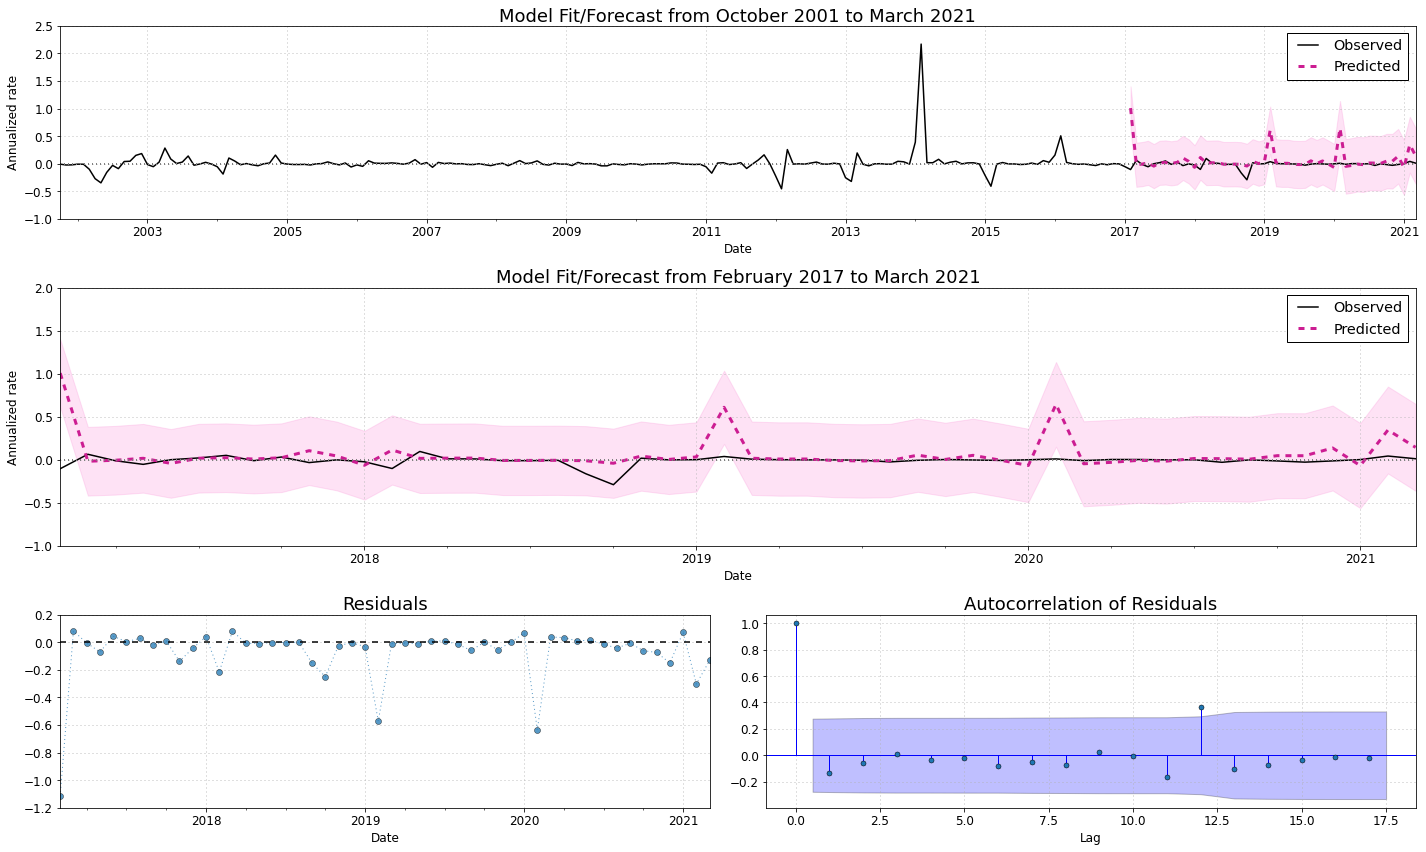

In [64]:
f = plot_forecast(data=pred_results1, data_index_col=0, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 3 month

In [65]:
var_corr_3 = (df_3.corr().sort_values('target'))
var_corr_3.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_7,-0.123403,0.266797,-0.047760,-0.303717,-0.258925,0.015086,0.309555,-0.270888,0.000435,-0.096741,...,-0.302809,-0.301274,-0.299126,-0.297713,-0.298013,-0.299952,-0.302859,-0.306008,-0.309327,0.009860
ppi_w_yoy_ch_11,-0.114681,-0.011404,-0.194142,-0.235122,-0.186413,-0.187758,-0.378865,0.627609,0.186339,0.443299,...,0.574249,0.575198,0.575363,0.574543,0.573547,0.572531,0.571649,0.570705,0.569608,-0.006674
cpi_yoy_ch_8,-0.101863,0.279015,-0.054131,-0.340386,-0.279915,0.029714,0.229400,-0.269890,-0.016954,-0.094032,...,-0.300562,-0.300124,-0.298079,-0.295544,-0.293839,-0.294027,-0.295876,-0.298627,-0.301643,0.003127
cpi_yoy_ch_6,-0.099597,0.248302,-0.071173,-0.277061,-0.217359,-0.014270,0.392085,-0.269906,-0.005669,-0.103122,...,-0.302150,-0.300305,-0.299110,-0.299564,-0.301554,-0.304500,-0.307722,-0.311102,-0.314564,0.008083
cpi_mom_ch_8,-0.092180,-0.000695,0.106537,-0.048373,-0.072263,-0.074794,0.338722,-0.109871,0.031654,-0.061907,...,-0.117816,-0.116028,-0.116132,-0.119177,-0.124526,-0.130754,-0.135510,-0.138353,-0.140269,-0.096976


In [66]:
var_corr_3.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
exp_mom_ch_1,0.106799,-0.160359,0.009003,0.022233,0.008192,0.247111,0.058289,0.044633,0.009495,0.092201,...,-0.027649,-0.020448,-0.015197,-0.012618,-0.011131,-0.009351,-0.006781,-0.002736,0.003019,-0.028421
ppi_w_yoy_ch_1,0.110531,-0.332498,-0.170213,-0.273905,-0.291792,-0.071815,-0.169927,0.679681,0.015540,0.918527,...,0.581900,0.579259,0.576543,0.573926,0.571448,0.569090,0.566704,0.564564,0.562742,0.019135
imp_mom_ch_6,0.114747,-0.106652,0.096163,0.194711,0.097659,-0.074405,0.294073,-0.173182,-0.033120,-0.050492,...,-0.220429,-0.225212,-0.231497,-0.238376,-0.244832,-0.250440,-0.254829,-0.257477,-0.257914,-0.054349
imp_mom_ch_7,0.144294,-0.114749,0.181440,0.111153,0.126739,-0.024701,0.292737,-0.163749,-0.039575,-0.040696,...,-0.208889,-0.211540,-0.215994,-0.222036,-0.228735,-0.235141,-0.240704,-0.244990,-0.247542,0.019808
target,1.000000,-0.081699,0.039481,0.090343,0.030000,0.019071,-0.046964,0.026172,-0.019308,0.102231,...,0.016382,0.016013,0.015983,0.016031,0.016155,0.016844,0.018396,0.019771,0.020494,-0.015272


In [67]:
X3 = df_3.drop(['target'],axis = 1)
#X3.head()

In [68]:
y3 = df_3.target
#y3

In [69]:
feature_names = X3.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X3,y3)
feature_names[rfe.get_support()]

array(['cpi_mom_ch', 'cpi_yoy_ch', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'cpi_mom_ch_1', 'cpi_mom_ch_12', 'cpi_mom_ch_13', 'cpi_yoy_ch_1',
       'cpi_yoy_ch_2', 'ppi_w_mom_ch_12'], dtype=object)

In [70]:
model_exvar = ['cpi_mom_ch','market3']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_3.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_3.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [71]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  182
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                  30.432
Date:                                 Tue, 31 Aug 2021   AIC                            -48.864
Time:                                         13:19:37   BIC                            -30.049
Sample:                                              0   HQIC                           -41.229
                                                 - 182                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3573     14.502      0.025      0.980     -28.066      28

In [72]:
sar3_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sar3_mod_fit = sar3_model.fit()

sar3_pred = sar3_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

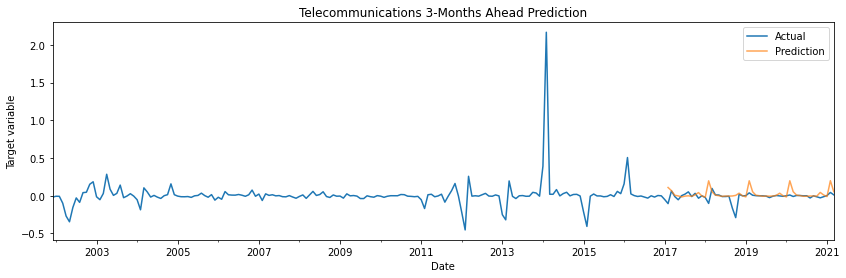

In [73]:
sar3_pred_mean = sar3_pred.predicted_mean
sar3_pred_ci = sar3_pred.conf_int()
ax = df_3.target.plot(label='Actual')
sar3_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 3-Months Ahead Prediction')
plt.legend()
plt.show()

In [74]:
metrics1 = forecast_accuracy(y_test, sar3_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 6.83247
MAE: 0.04516


In [75]:
pred_results3 = pd.DataFrame(df_3.target).join(sar3_pred_mean).join(sar3_pred_ci)
pred_results3

,target,predicted_mean,lower target,upper target
date,,,,
2001-12-01,-0.020024,NaN,NaN,NaN
2002-01-01,-0.007431,NaN,NaN,NaN
2002-02-01,-0.008379,NaN,NaN,NaN
2002-03-01,-0.099550,NaN,NaN,NaN
2002-04-01,-0.270032,NaN,NaN,NaN
...,...,...,...,...
2020-11-01,-0.028466,0.043115,-0.346650,0.432879
2020-12-01,-0.014038,0.009588,-0.380156,0.399332
2021-01-01,0.001549,-0.011436,-0.401180,0.378308


* Index converted to datetime. Please verify example below.
from 2001-12-01 00:00:00 to 2001-12-01 00:00:00

* Dropping duplicate index values. Keeping last.



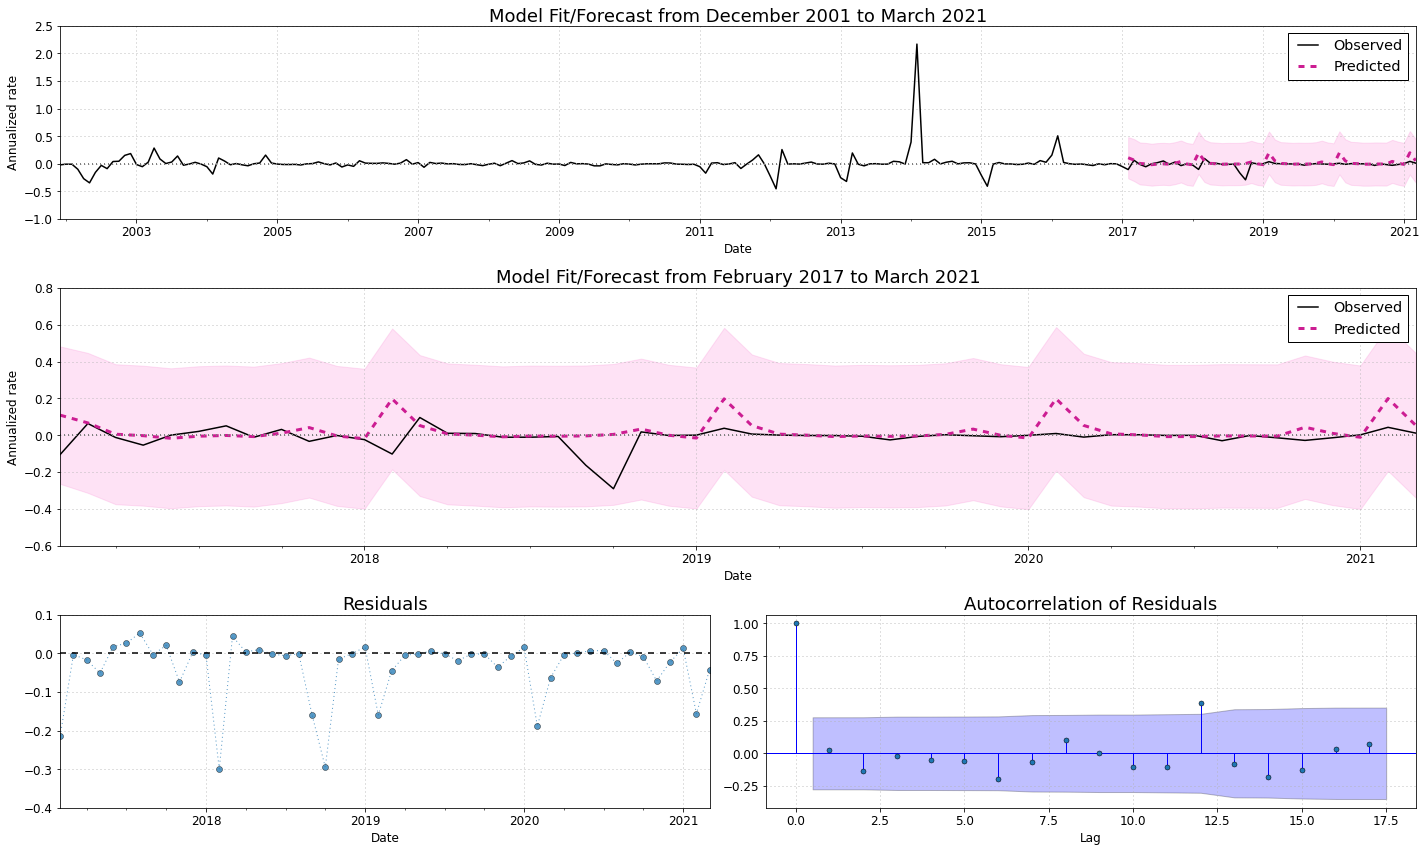

In [76]:
f = plot_forecast(data=pred_results3, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 6 month

In [77]:
var_corr_6 = (df_6.corr().sort_values('target'))
var_corr_6.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
market12,-0.123259,1.000000,-0.071121,-0.176170,-0.204460,-0.093658,-0.126922,-0.196216,-0.031067,-0.339364,...,-0.116467,-0.114459,-0.112832,-0.111707,-0.110954,-0.110410,-0.110056,-0.109893,-0.110199,-0.017071
cpi_yoy_ch_4,-0.122854,0.131455,0.069153,-0.189718,-0.149001,-0.090343,0.575735,-0.252753,-0.009877,-0.093322,...,-0.287228,-0.287548,-0.289512,-0.292449,-0.295632,-0.298992,-0.302459,-0.306289,-0.310952,0.012221
ppi_w_yoy_ch_8,-0.115323,-0.066882,-0.196980,-0.250395,-0.184454,-0.251635,-0.290552,0.645639,0.186047,0.539291,...,0.577249,0.576207,0.575174,0.574295,0.573356,0.572261,0.570616,0.568418,0.565841,-0.002541
cpi_yoy_ch_5,-0.101208,0.204676,-0.021447,-0.250047,-0.182082,-0.050582,0.476631,-0.251554,-0.001808,-0.085789,...,-0.283561,-0.281837,-0.282014,-0.283877,-0.286657,-0.289712,-0.292982,-0.296390,-0.300198,0.006182
cpi_yoy_ch_3,-0.099041,0.056159,0.135265,-0.078379,-0.107411,-0.153876,0.680938,-0.248407,0.007022,-0.098773,...,-0.288891,-0.290942,-0.293933,-0.297190,-0.300607,-0.304111,-0.307959,-0.312620,-0.318229,0.016318


In [78]:
var_corr_6.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
ppi_w_mom_ch_2,0.089602,-0.062920,-0.088834,-0.073258,-0.080325,-0.014468,-0.051827,0.159475,-0.052738,0.231891,...,0.137219,0.137088,0.137528,0.137723,0.137249,0.135765,0.134755,0.134289,0.135051,-0.021303
ppi_w_mom_ch_6,0.095539,-0.177745,-0.039388,-0.044592,-0.101068,0.065335,-0.014562,0.193964,-0.127871,0.228699,...,0.160073,0.159329,0.157985,0.156988,0.156430,0.156319,0.156916,0.157128,0.156615,-0.001549
imp_mom_ch_3,0.114587,-0.176762,0.014072,0.212104,0.189774,0.164518,0.302166,-0.175314,0.015530,-0.058995,...,-0.242632,-0.249145,-0.254815,-0.259261,-0.261948,-0.262400,-0.260146,-0.255576,-0.249849,-0.054218
imp_mom_ch_4,0.144043,-0.137141,0.000553,0.234011,0.139518,0.041427,0.311873,-0.166448,-0.006503,-0.044565,...,-0.227933,-0.234689,-0.241168,-0.246803,-0.251148,-0.253739,-0.254099,-0.251753,-0.247092,0.019889
target,1.000000,-0.123259,0.014408,0.062510,0.071750,0.036640,-0.030663,0.026659,0.017058,0.075189,...,0.014582,0.014709,0.015404,0.016969,0.018356,0.019084,0.018950,0.019043,0.019698,-0.015420


In [79]:
X6 = df_6.drop(['target'],axis = 1)
#X6.head()

In [80]:
y6 = df_6.target
#y6

In [81]:
feature_names = X6.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=5, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X6,y6)
feature_names[rfe.get_support()]

array(['cpi_mom_ch_5', 'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13',
       'ppi_w_yoy_ch_1', 'ppi_w_yoy_ch_2'], dtype=object)

In [112]:
model_exvar = ['market6','imp_mom_ch','exp_mom_ch','ppi_w_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_6.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_6.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [113]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                  19.653
Date:                             Tue, 31 Aug 2021   AIC                            -23.305
Time:                                     13:37:48   BIC                              1.639
Sample:                                          0   HQIC                           -13.181
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0346      0.083     -0.416      0.678      -0.198       0.129
x2            -1.3235      

In [114]:
sar6_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar6_mod_fit = sar6_model.fit()

sar6_pred = sar6_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

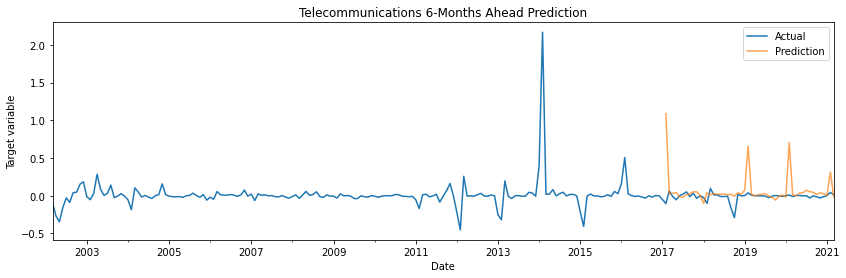

In [115]:
sar6_pred_mean = sar6_pred.predicted_mean
sar6_pred_ci = sar6_pred.conf_int()
ax = df_6.target.plot(label='Actual')
sar6_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 6-Months Ahead Prediction')
plt.legend()
plt.show()


In [116]:
metrics1 = forecast_accuracy(y_test, sar6_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 2.73308
MAE: 0.09750


In [117]:
pred_results6 = pd.DataFrame(df_6.target).join(sar6_pred_mean).join(sar6_pred_ci)
pred_results6

,target,predicted_mean,lower target,upper target
date,,,,
2002-03-01,-0.099550,NaN,NaN,NaN
2002-04-01,-0.270032,NaN,NaN,NaN
2002-05-01,-0.346031,NaN,NaN,NaN
2002-06-01,-0.156167,NaN,NaN,NaN
2002-07-01,-0.029472,NaN,NaN,NaN
...,...,...,...,...
2020-11-01,-0.028466,0.037104,-0.471285,0.545494
2020-12-01,-0.014038,0.026732,-0.481657,0.535122
2021-01-01,0.001549,0.002332,-0.506058,0.510721


* Index converted to datetime. Please verify example below.
from 2002-03-01 00:00:00 to 2002-03-01 00:00:00

* Dropping duplicate index values. Keeping last.



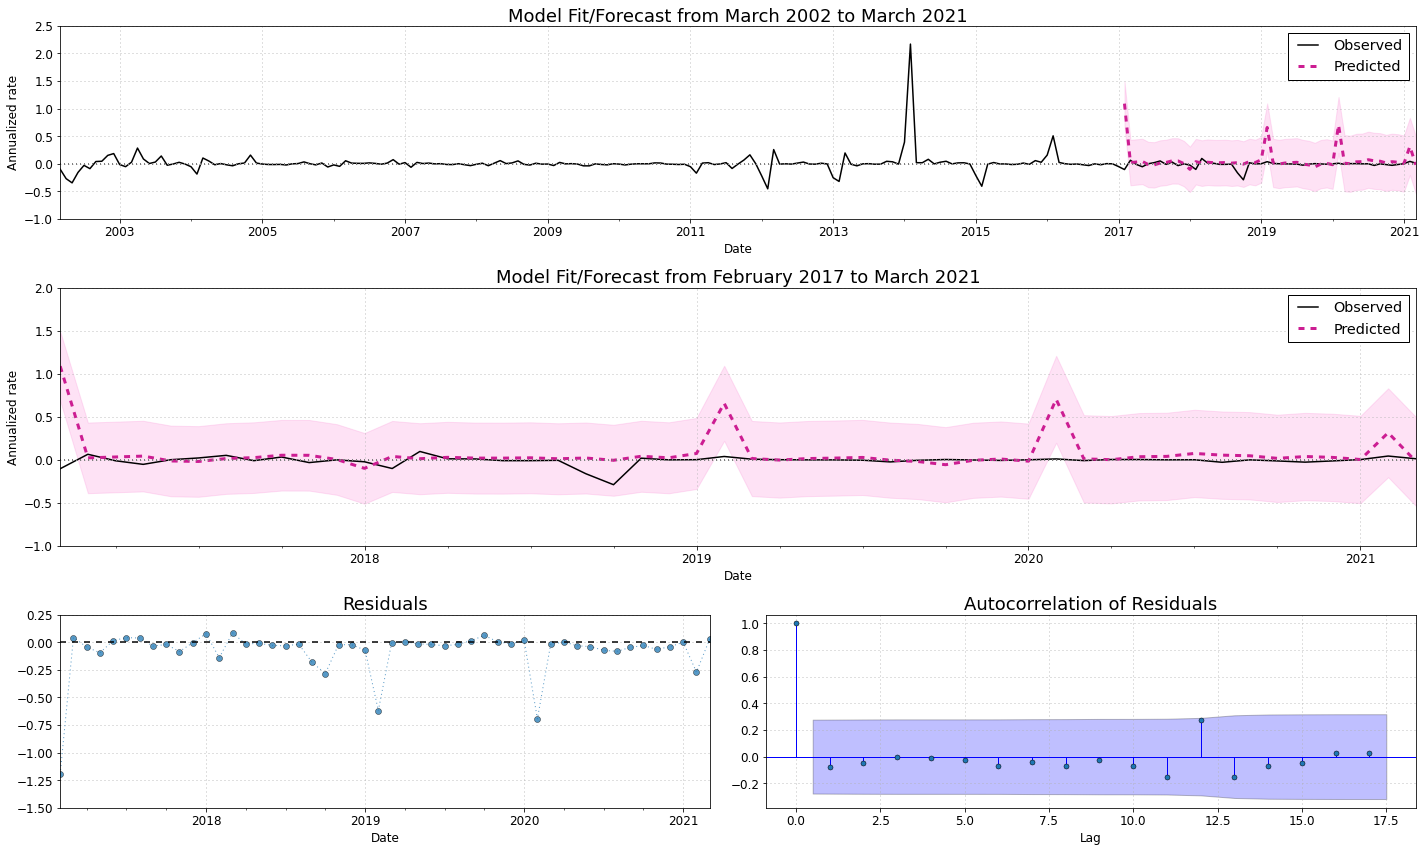

In [118]:
f = plot_forecast(data=pred_results6, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 12 month

In [119]:
var_corr_12 = (df_12.corr().sort_values('target'))
var_corr_12.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
ppi_w_yoy_ch_2,-0.115812,-0.323377,-0.154984,-0.262360,-0.286443,-0.026813,-0.142471,0.678942,0.003039,0.846452,...,0.579423,0.577220,0.574616,0.572009,0.569566,0.567332,0.565032,0.562426,0.559621,0.002873
imp_yoy_ch_6,-0.109524,-0.055241,0.265028,0.114190,0.139333,0.029623,0.367072,-0.120612,0.004456,0.115964,...,-0.229259,-0.230719,-0.233382,-0.237355,-0.242530,-0.248721,-0.255481,-0.262208,-0.268289,0.003142
ppi_w_mom_ch_2,-0.108305,-0.061388,-0.089831,-0.070239,-0.061857,0.013098,-0.035434,0.144297,-0.080297,0.229177,...,0.116106,0.115646,0.116035,0.115973,0.115052,0.113066,0.111915,0.112112,0.113778,-0.072557
imp_yoy_ch_5,-0.107177,-0.100865,0.278397,0.158729,0.157995,0.035294,0.415433,-0.133762,0.013073,0.104571,...,-0.239221,-0.241812,-0.245739,-0.250879,-0.257017,-0.263802,-0.270641,-0.276915,-0.282268,0.002312
imp_yoy_ch_7,-0.099543,-0.024028,0.245977,0.078130,0.128188,0.042445,0.320767,-0.104990,-0.010176,0.122177,...,-0.217805,-0.218594,-0.220114,-0.222802,-0.226780,-0.231971,-0.238136,-0.244824,-0.251440,-0.004341


In [120]:
var_corr_12.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_12,0.081808,0.252041,-0.331852,-0.262291,-0.231169,-0.010658,-0.067551,-0.292599,-0.029444,-0.100926,...,-0.314897,-0.318238,-0.322009,-0.325420,-0.327445,-0.327471,-0.325629,-0.323096,-0.321339,0.010689
exp_mom_ch_11,0.084561,0.000134,0.057478,-0.046683,-0.131422,-0.081462,0.223231,0.078779,-0.003107,0.124155,...,0.049698,0.051508,0.055716,0.060886,0.062849,0.054540,0.035266,0.010337,-0.008311,-0.092499
exp_mom_ch_12,0.110811,0.042535,0.092689,-0.090465,-0.133032,-0.141620,0.138688,0.054937,0.010916,0.093762,...,0.024378,0.024623,0.026291,0.030313,0.035230,0.036768,0.028406,0.009506,-0.014449,-0.000167
exp_mom_ch_13,0.120947,0.081185,0.098997,-0.125827,-0.102466,-0.176583,0.024541,0.036729,0.036847,0.091742,...,0.007782,0.007529,0.007656,0.009160,0.012990,0.017665,0.019318,0.011374,-0.006776,0.044206
target,1.000000,0.070804,-0.079381,-0.024624,0.066445,0.053104,-0.050230,-0.020629,0.063552,-0.069413,...,-0.014177,-0.014137,-0.013527,-0.012604,-0.012542,-0.013370,-0.015152,-0.017560,-0.020509,-0.027297


In [121]:
X12 = df_12.drop(['target'],axis = 1)
#X12.head()

In [122]:
y12 = df_12.target
#y12

In [123]:
feature_names = X12.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X12,y12)
feature_names[rfe.get_support()]

array(['cpi_mom_ch_1', 'cpi_mom_ch_13', 'cpi_yoy_ch_1', 'cpi_yoy_ch_2',
       'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13', 'ppi_w_yoy_ch_1',
       'ppi_w_yoy_ch_2', 'exp_mom_ch_13', 'exp_yoy_ch_2'], dtype=object)

In [124]:
model_exvar = ['market12','imp_mom_ch','exp_mom_ch','ppi_w_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [125]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  173
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                  26.756
Date:                                 Tue, 31 Aug 2021   AIC                            -37.512
Time:                                         13:48:03   BIC                            -12.860
Sample:                                              0   HQIC                           -27.502
                                                 - 173                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0229      0.095      0.241      0.810      -0.163       0

In [132]:
sar12_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,1,12)
                , exog = x_train
                )

sar12_mod_fit = sar12_model.fit()

sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

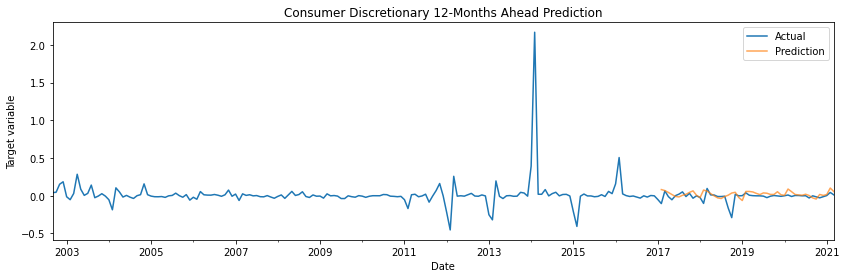

In [148]:
sar12_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,1,12)
                , exog = x_train
                )

sar12_mod_fit = sar12_model.fit()

sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 12-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

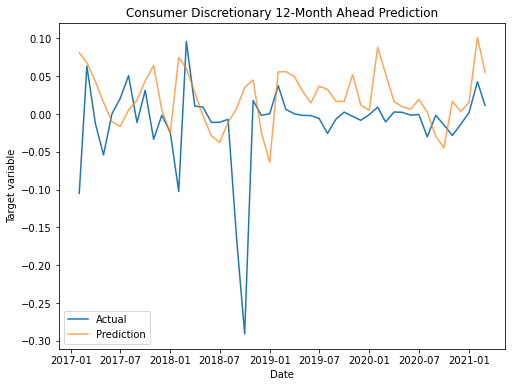

In [149]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_12[df_12.index >= first_date].index, df_12[df_12.index >= first_date].target, label = 'Actual')
ax.plot(sar12_pred_mean.index, sar12_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 12-Month Ahead Prediction')
plt.legend()
plt.show()

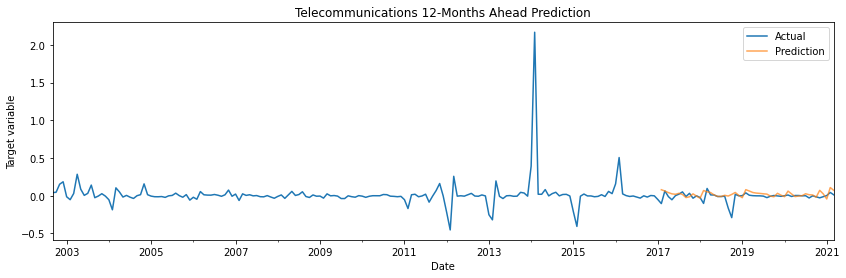

In [133]:
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 12-Months Ahead Prediction')
plt.legend()
plt.show()

In [134]:
metrics1 = forecast_accuracy(y_test, sar12_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 2.27169
MAE: 0.04337


In [135]:
pred_results12 = pd.DataFrame(df_12.target).join(sar12_pred_mean).join(sar12_pred_ci)
pred_results12

,target,predicted_mean,lower target,upper target
date,,,,
2002-09-01,0.040499,NaN,NaN,NaN
2002-10-01,0.045425,NaN,NaN,NaN
2002-11-01,0.151730,NaN,NaN,NaN
2002-12-01,0.184430,NaN,NaN,NaN
2003-01-01,-0.014347,NaN,NaN,NaN
...,...,...,...,...
2020-11-01,-0.028466,0.070982,-0.320736,0.462700
2020-12-01,-0.014038,0.024323,-0.367395,0.416041
2021-01-01,0.001549,-0.043587,-0.435305,0.348131


* Index converted to datetime. Please verify example below.
from 2002-09-01 00:00:00 to 2002-09-01 00:00:00

* Dropping duplicate index values. Keeping last.



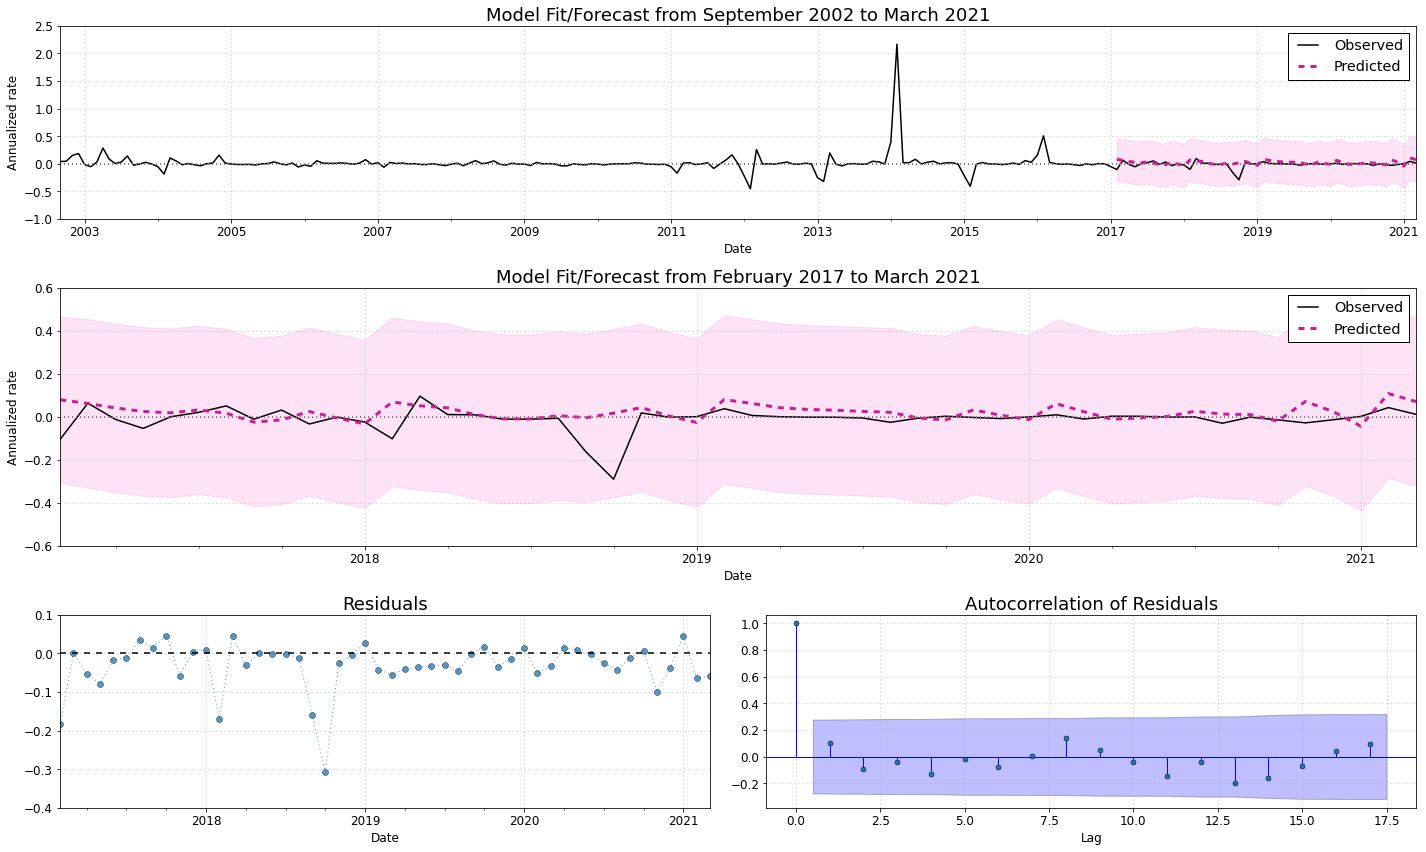

In [136]:
f = plot_forecast(data=pred_results12, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 18 month

In [150]:
var_corr_18 = (df_18.corr().sort_values('target'))
var_corr_18.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
imp_yoy_ch,-0.106142,-0.364834,0.257232,0.348562,0.308354,0.134653,0.518349,-0.173606,0.017421,0.031572,...,-0.288396,-0.295360,-0.301664,-0.307094,-0.311709,-0.315723,-0.319202,-0.322028,-0.323867,0.010212
ppi_w_mom_ch_7,-0.095106,-0.147029,-0.025708,-0.043885,-0.110310,-0.103289,-0.031014,0.196184,0.091187,0.302428,...,0.165382,0.165323,0.164436,0.162479,0.161132,0.160237,0.159865,0.159624,0.158985,0.016341
imp_yoy_ch_1,-0.094004,-0.332782,0.277216,0.317231,0.282724,0.114510,0.533319,-0.162047,0.017036,0.050722,...,-0.275683,-0.282650,-0.289539,-0.295792,-0.301196,-0.305830,-0.309832,-0.313271,-0.316032,0.008957
cpi_mom_ch_3,-0.090290,-0.117271,0.133110,0.330451,0.061564,-0.100323,0.336500,-0.058463,0.015697,-0.043925,...,-0.091985,-0.096730,-0.099314,-0.100855,-0.102251,-0.102460,-0.101330,-0.100226,-0.099891,-0.041556
imp_mom_ch_10,-0.085972,-0.085383,0.192705,0.004242,0.053779,0.002465,0.187028,-0.061934,0.082364,0.082398,...,-0.109383,-0.110798,-0.111462,-0.111658,-0.112291,-0.114040,-0.117324,-0.122787,-0.129929,0.018112


In [151]:
var_corr_18.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
exp_mom_ch_7,0.119230,-0.141544,-0.107222,-0.021641,0.015461,-0.025969,0.186196,0.061034,0.120882,0.172801,...,0.029666,0.021551,0.003010,-0.021083,-0.039432,-0.047348,-0.045508,-0.040134,-0.034918,0.044079
cpi_yoy_ch_11,0.124990,0.273117,-0.284099,-0.306151,-0.239007,0.031800,0.003413,-0.285489,-0.020785,-0.090548,...,-0.318209,-0.322071,-0.325195,-0.326797,-0.326349,-0.324079,-0.321072,-0.318903,-0.318694,-0.003140
cpi_yoy_ch_12,0.130956,0.251146,-0.332229,-0.262974,-0.233389,-0.014244,-0.066446,-0.296433,-0.027834,-0.100454,...,-0.325066,-0.328432,-0.331715,-0.334482,-0.335944,-0.335558,-0.333224,-0.330030,-0.327554,0.000833
cpi_yoy_ch_13,0.133759,0.203445,-0.355533,-0.234639,-0.223442,0.007126,-0.066579,-0.304705,-0.043383,-0.123470,...,-0.330447,-0.333010,-0.335908,-0.338908,-0.341566,-0.343083,-0.342649,-0.340164,-0.336720,0.002291
target,1.000000,0.080745,-0.002886,-0.015407,-0.076387,0.033691,-0.017803,-0.004632,-0.019419,-0.043652,...,-0.005478,-0.007902,-0.010901,-0.014170,-0.015860,-0.016237,-0.015095,-0.013761,-0.012246,-0.045393


In [152]:
X18 = df_18.drop(['target'],axis = 1)
#X18.head()

In [153]:
y18 = df_18.target
#y18

In [154]:
feature_names = X18.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X18,y18)
feature_names[rfe.get_support()]

array(['cpi_mom_ch_1', 'cpi_mom_ch_13', 'cpi_yoy_ch_1', 'cpi_yoy_ch_2',
       'ppi_w_mom_ch_13', 'ppi_w_yoy_ch_2', 'imp_mom_ch_1',
       'imp_mom_ch_13', 'imp_yoy_ch_1', 'imp_yoy_ch_2'], dtype=object)

In [155]:
model_exvar = ['imp_mom_ch','exp_mom_ch','ppi_w_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_18.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_18.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [156]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  167
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                  15.440
Date:                             Tue, 31 Aug 2021   AIC                            -16.880
Time:                                     14:49:26   BIC                              4.424
Sample:                                          0   HQIC                            -8.226
                                             - 167                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.1392      3.545     -0.603      0.546      -9.087       4.809
x2            -0.8579      

In [157]:
sar18_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar18_mod_fit = sar18_model.fit()

sar18_pred = sar18_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

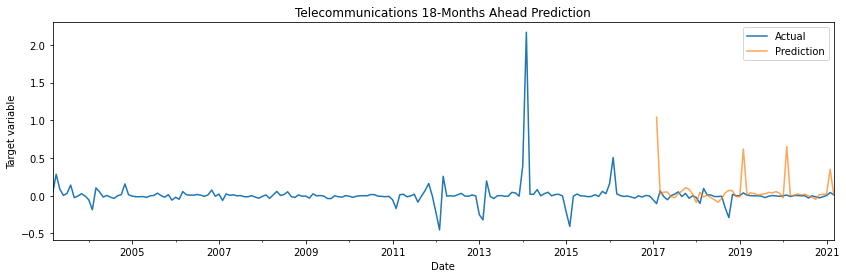

In [158]:
sar18_pred_mean = sar18_pred.predicted_mean
sar18_pred_ci = sar18_pred.conf_int()
ax = df_18.target.plot(label='Actual')
sar18_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 18-Months Ahead Prediction')
plt.legend()
plt.show()

In [159]:
metrics1 = forecast_accuracy(y_test, sar18_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 1.80351
MAE: 0.10012


In [ ]:
pred_results18 = pd.DataFrame(df_18.target).join(sar18_pred_mean).join(sar18_pred_ci)
pred_results18

In [ ]:
f = plot_forecast(data=pred_results18, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)